In [1]:
from math import inf
from math import log
import numpy as np
from scipy.stats import nbinom
from collections import defaultdict
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# log func

In [2]:
def log_func(number):
    if number > 0:
        return log(number)
    else:
        return -inf

# log-sum-exp

In [3]:
# HMM Notes p17
# log sum(exp(x1)+exp(x2)+...)
# x: list
# result: scalar
def logSumExp(x):
    m = max(x)
    if m == -inf: # infinity
        return -inf
    else:
        minus_m = np.array(x) - m
        result = m + log(sum(np.exp(minus_m)))
        return result   

In [ ]:
# examples
# x = list(range(-100,-50))
# log(sum(np.exp(x)))
# logSumExp(x)

# log likelihood f(x)

In [4]:
# Notes p2
# x: scalar. Realization from NB distribution
# alpha, beta: scalar. Parameters from Gamma distribution
# E: list. Normalization factor for n-th sequence
# result: scalar. Log likelihood f(x)
def lnNB(x, alpha, beta, E):
    r = alpha
    p = beta / (E+beta)

    result = nbinom.logpmf(x, r, p) # x follows NB(alpha, beta/(E+beta))
    return result

In [ ]:
# examples
# x = 50
# alpha = 1
# beta = 0.1
# E = 10
# lnNB(x, alpha, beta, E)

# Forward

In [ ]:
# RNA_data: a list of elements 
# observed_data: height
# trans: dictionary, key: string (start codon); value: rho
# alpha_list: a list with length 10 (index 0 to 9)
# beta_list: a list with length 10 (index 0 to 9)
# E: normalizaton factor for each RNA sequence
# stop_codon_list: list of stop codons

In [5]:
def start_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E):
    
    # state 1 and 10 to state 1
    log_1_1 = prob_current[0] + log_func(1)
    log_10_1 = prob_current[9] + log_func(1)
    temp = [log_1_1, log_10_1]
    prob_next[0] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E)
    
    return prob_next

In [6]:
def start_codon_true(i, prob_current, prob_next, trans, next_codon, observed_data, alpha_list, beta_list, E):
    
    # state 1 and 10 to state 1
    log_1_1 = prob_current[0] + log_func(1 - trans[next_codon])
    log_10_1 = prob_current[9] + log_func(1)
    temp = [log_1_1, log_10_1]
    prob_next[0] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E)
    
    # state 1 to state 2
    log_1_2 = log_func(trans[next_codon])
    temp = prob_current[0] + log_1_2 + lnNB(observed_data[i+1], alpha_list[1], beta_list[1], E)
    prob_next[1] = temp
    
    return prob_next

In [7]:
def stop_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E):
    
    # state 4 and state 7 to state 5
    log_4_5 = prob_current[3] + log(1) 
    log_7_5 = prob_current[6] + log(1)
    temp = [log_4_5, log_7_5]
    prob_next[4] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
    
    return prob_next

In [8]:
def stop_codon_true(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E):
    
    # state 4 to state 5
    prob_next[4] = prob_current[3] + log(1) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
        
    # state 7 to state 8
    prob_next[7] = prob_current[6] + log(1) + lnNB(observed_data[i+1], alpha_list[7], beta_list[7], E)
    
    return prob_next

In [9]:
def forward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, num_sequence):

    # Find E and observed_data according the order of sequences
    
    E = E[num_sequence - 1]
    observed_data = observed_data[num_sequence - 1]
    RNA_data = RNA_data[num_sequence - 1]
    
    
    sequence_length = len(RNA_data) # length of data
    output = np.zeros((sequence_length, 10))
    prob_current = np.ones(10) * (-inf) # initialize probability, 10 different states
    prob_current[0] = lnNB(observed_data[0], alpha_list[0], beta_list[0], E)
    output[0] = prob_current
    
    for i in range(sequence_length - 1):
        start_codon = False
        stop_codon = False
        next_codon = ""
        prob_next = np.ones(10) * (-inf)
        
        # Check start and stop codon
        if i + 3 < sequence_length:
            next_codon = RNA_data[i+1] + RNA_data[i+2] + RNA_data[i+3]  
        if next_codon in trans.keys():
            start_codon = True
        if next_codon in stop_codon_list:
            stop_codon = True
        
        # start codon is false
        if start_codon == False:       
            
            prob_next = start_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E)
        
        # start codon is ture
        elif start_codon == True:   
            prob_next = start_codon_true(i, prob_current, prob_next, trans, next_codon, observed_data, 
                                           alpha_list, beta_list, E)
        
        # stop codon is ture
        if stop_codon == True: 

            prob_next = stop_codon_true(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E)
 
        # stop codon is false
        elif stop_codon == False:

            prob_next = stop_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E)
        
       
        # transter to next state with probability 1
        sure_to_transit = [1, 2, 4, 5, 7, 8]
        for k in sure_to_transit:
            temp = prob_current[k] + log(1) + lnNB(observed_data[i+1], alpha_list[k+1], beta_list[k+1], E)
            prob_next[k+1] = temp


        prob_current = prob_next
        output[i+1] = prob_current
  
    return output

In [10]:
def forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output = []
    for n in range(1, len(observed_data)+1):
        output.append(forward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, n))
    return output

# Backward

In [ ]:
# RNA_data: a list of elements 
# observed_data: height
# trans: dictionary, key: string (start codon); value: rho
# alpha_list: a list with length 10 (index 0 to 9)
# beta_list: a list with length 10 (index 0 to 9)
# E: normalizaton factor for each RNA sequence
# stop_codon_list: list of stop codons

In [11]:
def start_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, alpha_list, beta_list, E):
    
    # state 1 to state 1
    temp = prob_current_back[0] + log(1) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    prob_previous_back[0] = temp
 
    return prob_previous_back

In [12]:
def start_codon_true_back(i, prob_current_back, prob_previous_back, trans, next_codon, observed_data, alpha_list, beta_list, E):

    # state 1 to state 1, 2
    temp = log_func(1 - trans[next_codon])
    log_1_1 = prob_current_back[0] + temp + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    
    temp = log_func(trans[next_codon])
    log_1_2 = prob_current_back[1] + temp + lnNB(observed_data[i+1], alpha_list[1], beta_list[1], E) 
    
    temp = [log_1_1, log_1_2]
    prob_previous_back[0] = logSumExp(temp)
    
    return prob_previous_back

In [13]:
def stop_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, alpha_list, beta_list, E):
    
    # state 7 to state 5
    prob_previous_back[6] = prob_current_back[4] + log(1) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
      
    return prob_previous_back

In [14]:
def stop_codon_true_back(i, prob_current_back, prob_previous_back, observed_data, alpha_list, beta_list, E):
    
    # state 7 to state 8
    prob_previous_back[6] = prob_current_back[7] + log(1) + lnNB(observed_data[i+1], alpha_list[7], beta_list[7], E)
    
    return prob_previous_back

In [15]:
def backward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, num_sequence):
 
    # Find E and observed_data according the order of sequences
    E = E[num_sequence - 1]
    observed_data = observed_data[num_sequence - 1]
    RNA_data = RNA_data[num_sequence - 1]
    
    sequence_length = len(RNA_data) # length of data
    prob_current_back = list(np.zeros(10)) # initialize probability, 10 different states
    output = np.zeros((sequence_length, 10))
    output[sequence_length - 1] = prob_current_back  
    
    iteration_list = np.arange(0, sequence_length-1, 1).tolist()
    iteration_list.reverse()
    for i in iteration_list:
        start_codon = False
        stop_codon = False
        prob_previous_back = list(np.ones(10) * (-inf))
        next_codon = ""
        
        # Check start and stop codon
        if i + 3 < sequence_length:
            next_codon = RNA_data[i+1] + RNA_data[i+2] + RNA_data[i+3]  
            if next_codon in trans.keys():
                start_codon = True
            if next_codon in stop_codon_list:
                stop_codon = True
        
        # start codon is false
        if start_codon == False:       
            prob_previous_back = start_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, 
                                                        alpha_list, beta_list, E)
        
        # start codon is true
        elif start_codon == True:   
            prob_previous_back = start_codon_true_back(i, prob_current_back, prob_previous_back, trans, 
                                                       next_codon, observed_data, alpha_list, beta_list, E)
        
        # stop codon is true
        if stop_codon == True: 
            prob_previous_back = stop_codon_true_back(i, prob_current_back, prob_previous_back, observed_data, 
                                                      alpha_list, beta_list, E) 
        
        # stop codon is false
        elif stop_codon == False:
            prob_previous_back = stop_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, 
                                                       alpha_list, beta_list, E)
     
        
        # traster with probability 1 
        sure_to_transit = [2, 3, 4, 5, 6, 8, 9]
        for k in sure_to_transit:
            temp = prob_current_back[k] + log(1) + lnNB(observed_data[i+1], alpha_list[k], beta_list[k], E)
            prob_previous_back[k-1] = temp


        # state 10 to state 1     
        prob_previous_back[9] = prob_current_back[0] + log(1) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E)

        prob_current_back = prob_previous_back 
        output[i] = prob_current_back
        
    return output

In [16]:
def backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output = []
    for n in range(1, len(observed_data)+1):
        output.append(backward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, n))
    return output

# Incomplete log likelihood (simple) with backward (test accuracy)

In [17]:
def incomplete_log_likelihood(backward, observed_data, alpha_list, beta_list, E):
   
    # initialize parameters
    temp_list = []
    
    # incomplete log likelihood
    for n in range(1, len(observed_data)+1):
        
        B1_1 = backward[n-1][0][0]
        nb = lnNB(observed_data[n-1][0], alpha_list[0], beta_list[0], E[n-1])
        temp_list.append(B1_1 + nb)
       
    return logSumExp(temp_list)

# Incomplete log likelihood (simple) with forward (actual use)

In [18]:
def incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E):
    
    # initialize parameters
    output_list = []
    
    # incomplete log likelihood
    for n in range(1, len(observed_data)+1):
    
        last_position = len(observed_data[n-1]) - 1
        output_list.append(logSumExp(forward[n-1][last_position]))
        
    return logSumExp(output_list)

# Compute L(simple)

In [73]:
def compute_L(forward, backward):
    
    output = []

    for n in range(1, len(forward)+1):
        sequence = np.zeros((len(forward[n-1]), 10))

        for t in range(1, len(forward[n-1])+1):
            
            temp = logSumExp((forward[n-1] + backward[n-1])[t-1])
                   
            sequence[t-1] = forward[n-1][t-1] + backward[n-1][t-1] - temp
            
        output.append(sequence)
    return output

# Compute H

In [74]:
def transprob_comp(curr_state, next_state, codon_specific, trans):
    if curr_state == 1:
        if next_state == 1:
            return log_func(1 - trans[codon_specific])
        elif next_state == 2:
            return log_func(trans[codon_specific])

In [75]:
def compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t, trans):
    transprob = transprob_comp(curr_state, next_state, codon_specific, trans)
    numerator = forward[num_sequence - 1][t - 1][curr_state - 1] +\
                transprob + lnNB(observed_data[num_sequence - 1][t], alpha_list[next_state - 1], beta_list[next_state - 1], E[num_sequence - 1]) + \
                backward[num_sequence - 1][t][next_state - 1]
    return numerator

In [76]:
def compute_H_deno(forward, backward, curr_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t, trans):

    output_list = [] 
        
    # case state1 to state1, 2
    if curr_state == 1:
        for next_state in [1, 2]:
            output_list.append(compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t, trans))
    
    return logSumExp(output_list)
        

In [77]:
def compute_H_codon(forward, backward, curr_state, next_state, codon_specific, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, num_sequence):
    
    # initialize parameters
    output = -inf
    numerator_list = []
    # check codon
    if t + 3 <= len(RNA_data[num_sequence - 1]):
        next_codon = RNA_data[num_sequence - 1][t] + RNA_data[num_sequence - 1][t+1] + RNA_data[num_sequence - 1][t+2]  
        
        if codon_specific == next_codon:
   
            numerator = compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t, trans)
    
            if numerator == -inf:
                return -inf
    
            denominator = compute_H_deno(forward, backward, curr_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t, trans)
        
            output = numerator - denominator
            
            
    return output

# store probabilities

In [78]:
def store_info(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, ci):
    temp = []
    
    n11_list = []
    n12_list = []
    
    for n in range(1, len(observed_data) + 1):
            
        for t in range(1, len(observed_data[n-1]) - 1):
            
            n11_list.append(compute_H_codon(forward, backward, 1, 1, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
            n12_list.append(compute_H_codon(forward, backward, 1, 2, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
           
  
    n11 = logSumExp(n11_list)
    n12 = logSumExp(n12_list)
   
        
    temp.append(np.exp(n11))
    temp.append(np.exp(n12))
   
    return temp

# One parameter (rou)

In [79]:
def update_parameter(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output = defaultdict(float)
    for ci in trans.keys():
        
        info = store_info(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, ci)
        
        deno_alpha = info[0]+info[1]
        
        output[ci] = info[1]/deno_alpha
         
    return output

# alpha - M

In [80]:
# Q function with respect to alpha
def object_function_alpha(x, state, forward, observed_data, beta_list, E, L): # list of alpha_m
    
    #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
    #alpha_current = [x] + list(alpha_list[1:])
    #neg_bio = NB_matrix(observed_data, alpha_current, beta_list, E)
    #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)  

    #L = compute_L(forward, backward)
    
    output = 0
    
    for n in range(1, len(forward)+1):
        for t in range(1, len(forward[n-1])+1):
            temp = lnNB(observed_data[n-1][t-1], x, beta_list[state-1], E[n-1])
            output += np.exp(L[n-1][t-1][state-1]) * temp
            
        
    return((-1)*output)

In [81]:
#new
def derivative_function_alpha(x, state, forward, observed_data, beta_list, E, L): # list of alpha_m
    
    #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
    #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)  
    #L = compute_L(forward, backward)
        
    output_sum = 0
    for n in range(1, len(observed_data)+1):           
              
        for t in range(1, len(observed_data[n-1])+1):
             
            sum_s = 0
            for s in range(1, observed_data[n-1][t-1]+1):
                    
                sum_s += 1/(x + observed_data[n-1][t-1] - s)
                                 
            latter = sum_s + log(beta_list[state-1] / (E[n-1] + beta_list[state-1]))
                
            output_sum += np.exp(L[n-1][t-1][state-1]) * latter
    
                
    
    return (-1)*output_sum

# beta_correction

In [82]:
def object_function_beta(x, state, forward, observed_data, alpha_list, E, L): # list of alpha_m
    
    #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
    #alpha_current = [x] + list(alpha_list[1:])
    #neg_bio = NB_matrix(observed_data, alpha_current, beta_list, E)
    #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)  

    #L = compute_L(forward, backward)
    
    output = 0
    
    for n in range(1, len(forward)+1):
        for t in range(1, len(forward[n-1])+1):
            temp = lnNB(observed_data[n-1][t-1], alpha_list[state-1], x, E[n-1])
            output += np.exp(L[n-1][t-1][state-1]) * temp
            
        
    return((-1)*output)
        

In [83]:
# new
def derivative_function_beta(x, state, forward, observed_data, alpha_list, E, L): # list of alpha_m
    #forward = forward_matrix(RNA_data, observed_data, alpha_list, x, E, trans, stop_codon_list)

    #neg_bio = NB_matrix(observed_data, alpha_list, x, E)
    #backward = backward_matrix(RNA_data, observed_data, alpha_list, x, E, trans, stop_codon_list) 
    #L = compute_L(forward, backward)
        
    output_sum = 0
    for n in range(1, len(observed_data)+1):
                 
        for t in range(1, len(observed_data[n-1])+1):
                
            first_term = alpha_list[state-1]/x
            second_term = (alpha_list[state-1]+observed_data[n-1][t-1])/(E[n-1]+x)
               
            output_sum += np.exp(L[n-1][t-1][state-1]) * (first_term - second_term)      
           
    return output_sum

# EM iteration

In [84]:
# RNA_data
# observed_data
# E[]
# stop_codon_list



def EM_iter(RNA_data, observed_data, trans_init, alpha_init, beta_init, epsilon, max_iter):
    
    trans = trans_init.copy()
    alpha_list = alpha_init.copy()
    beta_list = beta_init.copy()
    
    forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
    backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
    
    log_links = []
    log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_init, beta_init, E))
    
    delta = 1
    n_iter = 1
    print(log_links)
    while((delta > epsilon) and (n_iter < max_iter)):
        print("iteration" + str(n_iter))
        #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        curr_trans = trans.copy()
        curr_alpha_list = alpha_list.copy()
        curr_beta_list = beta_list.copy()
       
        L = compute_L(forward, backward)
        
        #update rho_u_ci, rho_ci, delta_ci
        trans = update_parameter(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        print(trans)
        
        # alpha_list
        state_list = np.arange(10)+1
        random.shuffle(state_list)
        
        for i in state_list:
            state = i
           
            print("state"+str(state))
            res = minimize(object_function_alpha, alpha_list[state-1], method='BFGS', tol = 1, jac=derivative_function_alpha, args = (state, forward, observed_data, beta_list, E, L), options={'disp': False, 'maxiter': 10,'gtol': 1})
            alpha_list[state-1] = res.x[0]
            print("alpha"+str(res.x[0]))
            
            res = minimize(object_function_beta, beta_list[state-1], method='nelder-mead', tol = 1, args = (state, forward, observed_data, alpha_list, E, L), options={'disp': False})
            beta_list[state-1] = res.x[0]
            print("beta"+str(res.x[0]))
           
            
        
        print(alpha_list)
        print(beta_list)

        
        forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
        
        # log likelihood
        log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E))
        delta = log_links[-1] - log_links[-2]
        n_iter += 1
        
        print(log_links)


    if (delta < 0):
        trans = curr_trans
        alpha_list = curr_alpha_list
        beta_list = curr_beta_list
        
    return (trans, alpha_list, beta_list)

# Viterbi

In [49]:
def start_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output):
    
    # state 1 and state 10 to state 1     
    log_1_1 = prob_current[0] + log(1) 
    log_10_1 = prob_current[9] + log(1) 
    if log_1_1 > log_10_1:
        output[i+1][0] = 1
    else:
        output[i+1][0] = 10
    temp = max(log_1_1, log_10_1)
    prob_next[0] = temp + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E)
    
    return (prob_next, output)

In [50]:
def start_codon_true_viterbi(i, prob_current, prob_next, trans, next_codon, observed_data, alpha_list, beta_list, E, output):
    
    # state 1 and state 10 to state 1
    log_1_1 = prob_current[0] + log_func(1 - trans[next_codon])
    log_10_1 = prob_current[9] + log(1)
    if log_1_1 > log_10_1:
        output[i+1][0] = 1
    else:
        output[i+1][0] = 10
    temp = max(log_1_1, log_10_1) 
    prob_next[0] = temp + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E)
    
    # state 1 to state 2
    log_1_2 = log_func(trans[next_codon])
    temp = prob_current[0] + log_1_2 + lnNB(observed_data[i+1], alpha_list[1], beta_list[1], E)
    prob_next[1] = temp
    output[i+1][1] = 1         

    return (prob_next, output)

In [51]:
def stop_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output):
    
    # state 4 and state 7 to state 5
    log_4_5 = prob_current[3] + log(1) 
    log_7_5 = prob_current[6] + log(1)
    if log_4_5 > log_7_5:
        output[i+1][4] = 4
    else:
        output[i+1][4] = 7
    temp = max(log_4_5, log_7_5)
    prob_next[4] = temp + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
    
    return (prob_next, output)

In [52]:
def stop_codon_true_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E,output):
    
    # state 4 to state 5
    prob_next[4] = prob_current[3] + log(1) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
    output[i+1][4] = 4
        
     # state 7 to state 8
    prob_next[7] = prob_current[6] + log(1) + lnNB(observed_data[i+1], alpha_list[7], beta_list[7], E)
    output[i+1][7] = 7
    
    return (prob_next, output)

In [53]:
def viterbi(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, num_sequence):

    # Find E and observed_data according the order of sequences
    
    E = E[num_sequence - 1]
    observed_data = observed_data[num_sequence - 1]
    RNA_data = RNA_data[num_sequence - 1]
    
    
    sequence_length = len(RNA_data) # length of data
    output = np.zeros((sequence_length, 10))
    prob_current = np.ones(10) * (-inf) # initialize probability, 10 different states
    prob_current[0] = lnNB(observed_data[0], alpha_list[0], beta_list[0], E)
    
    for i in range(sequence_length - 1):
        start_codon = False
        stop_codon = False
        next_codon = ""
        prob_next = np.ones(10) * (-inf)
        
        # Check start and stop codon
        if i + 3 < sequence_length:
            next_codon = RNA_data[i+1] + RNA_data[i+2] + RNA_data[i+3]  
        if next_codon in trans.keys():
            start_codon = True
        if next_codon in stop_codon_list:
            stop_codon = True
        
        # start codon is false
        if start_codon == False:       
            
            prob_next = start_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[0]
            output = start_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[1]
         
        # start codon is ture
        elif start_codon == True:   
            prob_next = start_codon_true_viterbi(i, prob_current, prob_next, trans, next_codon, observed_data, 
                                           alpha_list, beta_list, E, output)[0]
            output = start_codon_true_viterbi(i, prob_current, prob_next, trans, next_codon, observed_data, 
                                           alpha_list, beta_list, E, output)[1]
        
        # stop codon is ture
        if stop_codon == True: 

            prob_next = stop_codon_true_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[0]
            output = stop_codon_true_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[1]
 
        # stop codon is false
        elif stop_codon == False:

            prob_next = stop_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[0]
            output = stop_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[1]
        
       
        # transter to next state with probability 1
        sure_to_transit = [1, 2, 4, 5, 7, 8] 
        for k in sure_to_transit:
            temp = prob_current[k] + log(1) + lnNB(observed_data[i+1], alpha_list[k+1], beta_list[k+1], E)
            prob_next[k+1] = temp
            output[i+1][k+1] = k+1
    
        prob_current = prob_next
        
    
    output_list = [list(prob_current).index(max(prob_current))+1]
    start = len(output) - 1
    while start >= 1:
        index = int(output_list[-1] - 1)
        current = int(output[start][index])
        output_list.append(current)
        start -= 1
    
    output_list.reverse()
    return output_list

In [54]:
def viterbi_sequence(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output_list = []
    for i in range(len(RNA_data)):
        output_list.append(viterbi(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, i+1))
    return output_list

In [55]:
def differ_state(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, state_list_true):
    start = 0
    differ_list = []
    
    for end in range(100, 3001, 100): #GAI
        count = 0
        viterbi_output = viterbi_sequence(RNA_data[start:end], observed_data[start:end], 
                                          alpha_list[int(start/100)], beta_list[int(start/100)], 
                                          E, trans[int(start/100)], stop_codon_list) #GAI
        
        curr_state = state_list_true[start:end]
        for i in range(len(curr_state)):
            for j in range(len(curr_state[i])):
                if viterbi_output[i][j] != curr_state[i][j]:
                    count += 1
        
        differ_list.append(count)
        start += 100 #GAI
    
    return differ_list

# Start codon percentage

In [12]:
def percent(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, viterbi_truth, state_list_true):

    start = 0
    output_list = []
    output_codon_num = []
    
    for end in range(101, 3001, 100): #GAI
        
        if viterbi_truth == True:
            viterbi_output = viterbi_sequence(RNA_data[start:end], observed_data[start:end], 
                                          alpha_list[int(start/100)], beta_list[int(start/100)], 
                                          E, trans[int(start/100)], stop_codon_list) #GAI  
        else:
            viterbi_output = state_list_true[start:end]
        
        
        codon_num_list = []
        actual_start = []
        for sequence_num in range(len(viterbi_output)):
            start_codon = 0
            starts = [j for j, x in enumerate(viterbi_output[sequence_num]) if x == 10]
            ends = [j for j, x in enumerate(viterbi_output[sequence_num]) if x == 2]
            actual_start.append(len(ends))

            starts.insert(0, -1)

            if len(ends) == 0:
                ends.append(len(viterbi_output[sequence_num]) - 4)
                
            pairs = []
            for i in range(len(ends)):
                pairs.append((starts[i]+1, ends[i]))

            for pair in pairs:
                for i in range(pair[0], pair[1]+1):
                    codon = RNA_data[start+sequence_num][i] + RNA_data[start+sequence_num][i+1] + RNA_data[start+sequence_num][i+2]
                    #if codon in trans.keys():
                    if codon in trans[0].keys(): #GAI based on start codon
                        start_codon += 1
            codon_num_list.append(start_codon)
        
        # total num of codons for each dataset
        output_codon_num.append(sum(codon_num_list))
        # percentage
        output_list.append(sum(actual_start)/ sum(codon_num_list))
        
       
        start += 100 #GAI
    
    return output_list




# Simulate Data

In [19]:
random.seed(100)

mean_list_true = np.array([80, 350, 300, 250, 200, 150, 120, 320, 250, 220]) # mean

variance_list_true = mean_list_true*1.2
beta_list_true = 1/(variance_list_true/mean_list_true-1)
alpha_list_true = mean_list_true * beta_list_true


state_dict = defaultdict(int)
def generate_nb(state):
    return np.random.negative_binomial(alpha_list_true[state-1], beta_list_true[state-1]/(1+beta_list_true[state-1]))

In [20]:
def simulate():
    

    state_list = []
    
    # first five without AUG
    curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5)
    while 'AUG' in "".join(curr_RNA):
        curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5)
    curr_observed = [generate_nb(1), generate_nb(1), generate_nb(1), generate_nb(1), generate_nb(1)]
    state_list = [1, 1, 1, 1, 1]
    count = 5
    state = 1

    # if in state 1
    while state == 1:
        
        # check if AUG would occur
        start = random.choices([True, False], weights=np.ones(2), k = 1)[0]
        while start == False:      

            # if no, generate single base
            curr_RNA += random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 1)[0]
            curr_observed.append(generate_nb(1))
            state_list.append(1)
            count += 1
            start = random.choices([True, False], weights=np.ones(2), k = 1)[0] # check if AUG occurs
            if "".join(curr_RNA[-3:]) == 'AUG':
                curr_RNA = curr_RNA[:-3]
                curr_observed = curr_observed[:-3]
                state_list = state_list[:-3]
                count -= 3
                start = True

            if count >= 100:
                return (curr_RNA, curr_observed, state_list)

        curr_RNA += ['A', 'U', 'G']
        count += 3
        state = random.choices([1, 2], weights=[0.3, 0.7], k = 1)[0]
        if state == 1:
            curr_observed += [generate_nb(1), generate_nb(1), generate_nb(1)]
            state_list += [1, 1, 1]
       
          
    # if in state 2
    if state == 2:
      
        curr_observed += [generate_nb(2), generate_nb(3), generate_nb(4)]
        state_list += [2, 3, 4]
        repeat = random.choices(np.arange(20, 31), weights=np.ones(11), k = 1)[0]
        for i in range(repeat-2):
            curr_RNA += random.choices([['A', 'U', 'G'], ['G', 'U', 'U'], ['U', 'U', 'U']], weights=[0.5, 0.25, 0.25], k = 1)[0]
            curr_observed += [generate_nb(5), generate_nb(6), generate_nb(7)]
            state_list += [5, 6, 7]
            count += 3
        curr_RNA += random.choices([['U', 'A', 'A'], ['U', 'G', 'A'], ['U', 'A', 'G']], weights=[1, 1, 1], k = 1)[0]
        curr_observed += [generate_nb(8), generate_nb(9), generate_nb(10)]
        state_list += [8, 9, 10]
        count += 3

        # UTR (back to state 1)
        temp = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5)
        while 'AUG' in "".join(temp):
            temp = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5) 
        curr_RNA += temp
        curr_observed += [generate_nb(1), generate_nb(1), generate_nb(1), generate_nb(1), generate_nb(1)]
        state_list += [1, 1, 1, 1, 1]
        count += 5

      
    return (curr_RNA, curr_observed, state_list)




In [21]:
def simulate_sequences(transition_num): # how many transitonal region
    RNA_data = []
    observed_data = []
    state_list_true = []
    while transition_num > 0:
        
        # generate one transition
        temp = simulate()
        
        RNA_data += temp[0]
        observed_data += temp[1]
        state_list_true += temp[2]
        transition_num -= 1
        
    return (RNA_data, observed_data, state_list_true)
        

In [22]:
def simulate_neither(length):
    RNA_data = []
    observed_data = []
    state_list_true = []
    for num in range(length):
        curr_observed = []
        curr_state = []
        repeat = random.choices(np.arange(30, 51), weights=np.ones(21), k = 1)[0]
        curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = repeat)
        for i in range(repeat):
            curr_observed.append(generate_nb(1))
            curr_state.append(1)
        while 'AUG' in "".join(curr_RNA):
            get_index = ("".join(curr_RNA)).index('AUG')
            curr_RNA[get_index] = random.choices(['C', 'G', 'U'], weights=np.ones(3), k = 1)[0]
        RNA_data.append(curr_RNA)
        observed_data.append(curr_observed)
        state_list_true.append(curr_state)
    return (RNA_data, observed_data, state_list_true)
    

In [23]:
def simulate_sequences_all(total_sequence_num):
    
    # 5% data has no transitinal region
    neither = simulate_neither(int(total_sequence_num * 0.05))
    RNA_data = neither[0]
    observed_data = neither[1]
    state_list_true = neither[2]
    
    
    # 15% data has one transitional region
    for i in range(int(total_sequence_num * 0.15)): 
        sequence = simulate_sequences(1)
        RNA_data.append(sequence[0]) 
        observed_data.append(sequence[1])
        state_list_true.append(sequence[2])
    
    # 30% data has two transitional region
    for i in range(int(total_sequence_num * 0.3)): 
        sequence = simulate_sequences(2)
        RNA_data.append(sequence[0]) 
        observed_data.append(sequence[1])
        state_list_true.append(sequence[2])
        
    # 50% data has two transitional region
    for i in range(int(total_sequence_num * 0.5)): 
        sequence = simulate_sequences(3)
        RNA_data.append(sequence[0]) 
        observed_data.append(sequence[1])
        state_list_true.append(sequence[2])
        
    return (RNA_data, observed_data, state_list_true)
    
    

# Plots

<BarContainer object of 33 artists>

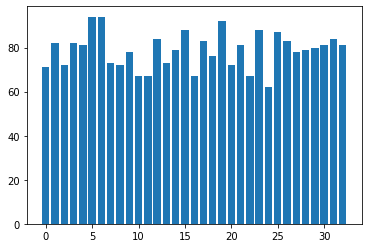

In [288]:
# no transition
test = simulate_sequences_all(100)    
plt.bar(np.arange(len(test[1][0])), test[1][0])

<BarContainer object of 103 artists>

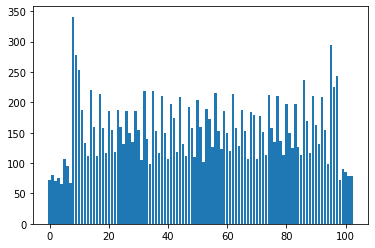

In [289]:
# one transition
plt.bar(np.arange(len(test[1][10])), test[1][10])

<BarContainer object of 186 artists>

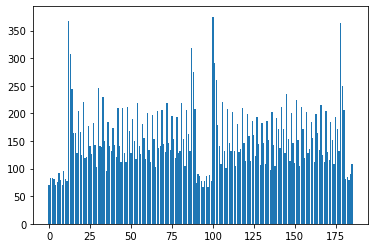

In [290]:
# two transition
plt.bar(np.arange(len(test[1][40])), test[1][40])

<BarContainer object of 260 artists>

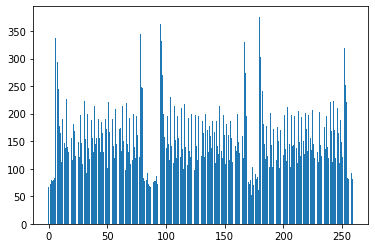

In [291]:
# three transition
plt.bar(np.arange(len(test[1][80])), test[1][80])

# Generate simulation data

In [24]:
# generate data with random seed
random.seed(0)
generated_sequences = simulate_sequences_all(3000) #GAI
RNA_data = generated_sequences[0]
observed_data = generated_sequences[1]
state_list_true = generated_sequences[2]

# shuffle data
c = list(zip(RNA_data, observed_data, state_list_true))
random.shuffle(c)
RNA_data, observed_data, state_list_true = zip(*c)


E = list(np.repeat(1, 3000)) #GAI
stop_codon_list = ['UAA', 'UGA', 'UAG']

In [19]:
# initial value
trans_prob = [{'AUG': 0.1}, {'AUG':0.2}, {'AUG':0.3}, {'AUG':0.4}]
alpha_list_prob = [np.array([ 10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
            np.array([  10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
            np.array([ 1, 5, 4, 3,  4,  3, 2, 5, 4,3])]
beta_list_prob = [beta_list_true + 2, beta_list_true * 2]

In [323]:
final_trans = []
final_alpha_list = []
final_beta_list = []

start_trans = []
start_alpha_list = []
start_beta_list = []

start = 0
count = 1
for end in range(100, 3001, 100): #GAI
    print("count " + str(count))
    
    trans_prob_copy = trans_prob.copy()
    # randomly generate index for trans
    random.seed(end)
    index = random.choice(range(4))
    trans = trans_prob_copy[index]
    start_trans.append(trans)
    
    # randomly generate index for alpha_list
    random.seed(end+1)
    index = random.choice(range(3))
    alpha_list = alpha_list_prob[index]
    start_alpha_list.append(alpha_list)
    
    # randomly generate index for beta_list
    random.seed(end+2)
    index = random.choice(range(2))
    beta_list = beta_list_prob[index]
    start_beta_list.append(beta_list)
    
    # run EM algorithm
    trans_copy = trans.copy()
    alpha_list_copy = alpha_list.copy()
    beta_list_copy = beta_list.copy()
    
    temp = EM_iter(RNA_data[start:end], observed_data[start:end], trans_copy, alpha_list_copy, beta_list_copy, 10e-10, 100)
    final_trans.append(temp[0])
    final_alpha_list.append(temp[1])
    final_beta_list.append(temp[2])
    
    start = end
    
    count += 1

count 1
[-5485.8144398246595]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.9708602512027643})
state1
alpha429.3971230282682
beta5.315625000000001
state8
alpha1786.2356171473425
beta5.775
state4
alpha1218.583804906309
beta6.2125
state2
alpha1578.3305477816132
beta5.950000000000001
state7
alpha574.4226367700489
beta4.571875
state9
alpha1485.8555002318274
beta5.993750000000001
state5
alpha1195.0836728742763
beta6.2562500000000005
state3
alpha1383.0584606254256
beta6.125000000000001
state6
alpha1009.8625574726752
beta6.4421875
state10
alpha1334.5521930768293
beta6.125000000000001
[ 429 1578 1383 1218 1195 1009  574 1786 1485 1334]
[5.315625  5.95      6.125     6.2125    6.25625   6.4421875 4.571875
 5.775     5.99375   6.125    ]
[-5485.8144398246595, -123.05057454185345]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9466613726323233})
state8
alpha1807.2100000000023
beta5.666718750000001
state4
alpha1547.5786182828665
beta6.2125
state3
alpha1799.1030518585846
beta6.01015625000000

alpha2880.361553935077
beta9.564843750000001
[ 746 3304 2880 2304 1612 1289 1057 2952 2354 2137]
[9.34375    9.440625   9.56484375 9.2640625  8.05288086 8.625
 8.828125   9.14375    9.384375   9.75      ]
[-5794.344553694016, -164.6238461568635, -131.2982142641302]
iteration3
defaultdict(<class 'float'>, {'AUG': 0.931428194792797})
state10
alpha2137.0
beta9.750000000000002
state9
alpha2354.0
beta9.384375000000002
state6
alpha1289.0
beta8.625000000000004
state1
alpha746.0
beta9.343750000000004
state4
alpha2304.0
beta9.264062500000001
state5
alpha1612.0
beta8.078046112060552
state7
alpha1057.0
beta8.828125000000004
state3
alpha2880.0
beta9.564843750000001
state2
alpha3304.0
beta9.440625
state8
alpha2952.0
beta9.143750000000002
[ 746 3304 2880 2304 1612 1289 1057 2952 2354 2137]
[9.34375    9.440625   9.56484375 9.2640625  8.07804611 8.625
 8.828125   9.14375    9.384375   9.75      ]
[-5794.344553694016, -164.6238461568635, -131.2982142641302, -131.2982142641302]
count 5
[-6676.678400491

beta6.825000000000001
state8
alpha2161.7915807831005
beta6.912500000000001
state2
alpha1366.175127110648
beta7.000000000000001
state3
alpha979.902696099364
beta6.65
state7
alpha825.6419937417836
beta6.65
state10
alpha1371.5699333918442
beta6.168750000000001
state6
alpha975.3815418421311
beta6.562500000000001
state9
alpha1710.6716721490295
beta6.912500000000001
[ 975 1366  979  804 1248  975  825 2161 1710 1371]
[6.5515625 7.        6.65      6.825     6.3       6.5625    6.65
 6.9125    6.9125    6.16875  ]
[-4353.166676016127, -581.8524905079785]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9198110313171182})
state4
alpha1603.7663390467196
beta6.782343750000001
state3
alpha1865.5863162022356
beta6.608437500000001
state6
alpha988.2596563472841
beta6.562500000000001
state1
alpha524.4919724532575
beta6.551562500000001
state9
alpha1710.0
beta6.826093750000002
state10
alpha1371.0
beta6.168750000000001
state5
alpha1263.3770200291374
beta6.300000000000001
state8
alpha2161.0
beta6.739687

[-5096.835559421527, -141.55600944857994]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9374759075994994})
state10
alpha2143.0
beta9.689062500000002
state2
alpha3304.6074661489524
beta9.440625
state7
alpha1058.8388496401328
beta8.798730468750003
state1
alpha750.2580271366738
beta9.375000000000004
state4
alpha2316.423790123891
beta9.203906250000001
state3
alpha2879.669156000734
beta9.564843750000001
state6
alpha1294.010000000001
beta8.625000000000004
state8
alpha2966.0
beta9.260546875000003
state9
alpha2363.0
beta9.444531250000002
state5
alpha1617.2686772631491
beta8.093750000000004
[ 750 3304 2879 2316 1617 1294 1058 2966 2363 2143]
[9.375      9.440625   9.56484375 9.20390625 8.09375    8.625
 8.79873047 9.26054688 9.44453125 9.6890625 ]
[-5096.835559421527, -141.55600944857994, -115.29381836739219]
iteration3
defaultdict(<class 'float'>, {'AUG': 0.9435897478251402})
state8
alpha2966.0
beta9.260546875000003
state10
alpha2143.0
beta9.689062500000002
state3
alpha2879.0
beta9.5648437

alpha1186.6651013060625
beta6.2125
state5
alpha1192.2792770123278
beta6.300000000000001
state8
alpha1779.0524740797716
beta5.6875
state9
alpha1464.8370553060504
beta6.037500000000001
[ 432 1522 1344 1186 1192 1012  574 1779 1464 1340]
[5.29375   5.99375   6.125     6.2125    6.3       6.43125   4.5609375
 5.6875    6.0375    6.3      ]
[-5150.890820221581, -118.50646005097995]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9394264931898888})
state10
alpha1361.2099999999984
beta6.1425
state6
alpha966.0795441600355
beta6.43125
state7
alpha547.7284505783402
beta4.5466845703125
state1
alpha423.70990100962507
beta5.277207031250001
state4
alpha1548.8760277393878
beta6.134843750000001
state9
alpha1464.0
beta5.886562500000001
state3
alpha1791.8862821378566
beta5.971875000000001
state8
alpha1779.0
beta5.509765625
state2
alpha2033.3363924691334
beta5.843906250000002
state5
alpha1259.1550693081144
beta6.300000000000001
[ 423 2033 1791 1548 1259  966  547 1779 1464 1361]
[5.27720703 5.84390625 

alpha2906.0
beta9.140625000000004
state6
alpha1296.0824019721035
beta8.625000000000004
state2
alpha3318.4863217204284
beta9.447597656250004
state1
alpha692.2481514076522
beta8.632812500000004
state10
alpha1712.0
beta7.774101562500004
state5
alpha1620.746493498721
beta8.099609375000004
state4
alpha2142.385462767116
beta8.673027343750002
state9
alpha2333.0
beta9.267070312500001
[ 692 3318 2542 2142 1620 1296 1047 2906 2333 1712]
[8.6328125  9.44759766 8.53125    8.67302734 8.09960938 8.625
 8.72265625 9.140625   9.26707031 7.77410156]
[-4834.75660929701, -629.9511840304503, -110.81781850978044, -110.01695963827174]
iteration4
defaultdict(<class 'float'>, {'AUG': 0.9364238856781938})
state10
alpha1712.0
beta7.774101562500004
state6
alpha1296.0
beta8.625000000000004
state3
alpha2542.0
beta8.531250000000004
state8
alpha2906.0
beta9.140625000000004
state5
alpha1620.0
beta8.099609375000004
state4
alpha2142.0
beta8.673027343750002
state1
alpha692.0
beta8.632812500000004
state2
alpha3318.0
beta

[-4208.861798692384, -616.7245254559359, -111.26524682453083, -107.303751687064]
iteration4
defaultdict(<class 'float'>, {'AUG': 0.9359423071663442})
state2
alpha2306.0
beta6.570115234375002
state1
alpha520.0100000000011
beta6.500976562500002
state4
alpha1621.0
beta6.488015624999999
state5
alpha1268.0
beta6.343750000000001
state10
alpha1356.0
beta6.173186523437501
state3
alpha1926.0
beta6.483750000000001
state9
alpha1682.0
beta6.739687500000001
state6
alpha984.0
beta6.562500000000001
state7
alpha784.0
beta6.541992187500002
state8
alpha2140.0
beta6.6975644531250005
[ 520 2306 1926 1621 1268  984  784 2140 1682 1356]
[6.50097656 6.57011523 6.48375    6.48801562 6.34375    6.5625
 6.54199219 6.69756445 6.7396875  6.17318652]
[-4208.861798692384, -616.7245254559359, -111.26524682453083, -107.303751687064, -107.3052162118147]
count 23
[-4961.3674971964465]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.38492015481724157})
state7
alpha803.4291997105408
beta6.671875
state3
alpha1960.641164

[-4177.214147776101, -629.8382444534255, -106.48455540198522, -106.28345608486903, -106.28345608486903]
count 26
[-5077.843303477535]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.9731222406739781})
state10
alpha1333.7082983653959
beta6.125000000000001
state4
alpha1225.9796443992723
beta6.300000000000001
state2
alpha1592.238753540044
beta5.906250000000001
state9
alpha1457.3701474542715
beta5.950000000000001
state6
alpha1005.0757276644678
beta6.453125
state3
alpha1400.8688131582853
beta6.081250000000001
state1
alpha435.5463984931979
beta5.29375
state8
alpha1750.2492314846695
beta5.775
state7
alpha573.3126481893191
beta4.571875
state5
alpha1193.7589539511096
beta6.278125000000001
[ 435 1592 1400 1225 1193 1005  573 1750 1457 1333]
[5.29375  5.90625  6.08125  6.3      6.278125 6.453125 4.571875 5.775
 5.95     6.125   ]
[-5077.843303477535, -104.5610583253459]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9410361158826365})
state9
alpha1457.0
beta5.8384374999999995
state8
alpha182

beta6.3206171875
state9
alpha1677.0
beta6.739687500000001
state7
alpha794.4988065846051
beta6.629218750000001
[ 521 2364 1898 1617 1267  985  794 2146 1677 1359]
[6.52018555 6.7396875  6.32061719 6.44642578 6.33383789 6.5625
 6.62921875 6.7396875  6.7396875  6.2125    ]
[-4156.269100814807, -628.9937127266237, -114.02851661959116, -112.63327183908419]
iteration4
defaultdict(<class 'float'>, {'AUG': 0.9349570873095743})
state9
alpha1677.0
beta6.739687500000001
state4
alpha1617.0
beta6.446425781250001
state10
alpha1359.0
beta6.2125
state3
alpha1898.0
beta6.3206171875
state6
alpha985.0
beta6.562500000000001
state7
alpha794.0
beta6.629218750000001
state8
alpha2146.0
beta6.739687500000001
state1
alpha521.0
beta6.520185546875
state5
alpha1267.0
beta6.333837890625
state2
alpha2364.0
beta6.7396875000000005
[ 521 2364 1898 1617 1267  985  794 2146 1677 1359]
[6.52018555 6.7396875  6.32061719 6.44642578 6.33383789 6.5625
 6.62921875 6.7396875  6.7396875  6.2125    ]
[-4156.269100814807, -628.993

In [324]:
start_trans

[{'AUG': 0.2},
 {'AUG': 0.1},
 {'AUG': 0.3},
 {'AUG': 0.3},
 {'AUG': 0.4},
 {'AUG': 0.3},
 {'AUG': 0.2},
 {'AUG': 0.4},
 {'AUG': 0.2},
 {'AUG': 0.4},
 {'AUG': 0.1},
 {'AUG': 0.3},
 {'AUG': 0.3},
 {'AUG': 0.2},
 {'AUG': 0.3},
 {'AUG': 0.1},
 {'AUG': 0.4},
 {'AUG': 0.3},
 {'AUG': 0.1},
 {'AUG': 0.4},
 {'AUG': 0.3},
 {'AUG': 0.3},
 {'AUG': 0.4},
 {'AUG': 0.1},
 {'AUG': 0.1},
 {'AUG': 0.4},
 {'AUG': 0.2},
 {'AUG': 0.3},
 {'AUG': 0.3},
 {'AUG': 0.2}]

In [325]:
start_alpha_list

[array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([10, 20, 18, 15, 10,  9

In [326]:
start_beta_list

[array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]),
 array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]),
 array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10

In [327]:
final_trans

[defaultdict(float, {'AUG': 0.9436335136310035}),
 defaultdict(float, {'AUG': 0.935928962688512}),
 defaultdict(float, {'AUG': 0.942673332793388}),
 defaultdict(float, {'AUG': 0.931428194792797}),
 defaultdict(float, {'AUG': 0.9378519497474725}),
 defaultdict(float, {'AUG': 0.9379943171191096}),
 defaultdict(float, {'AUG': 0.9389541536673892}),
 defaultdict(float, {'AUG': 0.937725951329929}),
 defaultdict(float, {'AUG': 0.9351544794633696}),
 defaultdict(float, {'AUG': 0.9391965479706337}),
 defaultdict(float, {'AUG': 0.9435897478251402}),
 defaultdict(float, {'AUG': 0.9251832733290148}),
 defaultdict(float, {'AUG': 0.944191826070198}),
 defaultdict(float, {'AUG': 0.9725512415134763}),
 defaultdict(float, {'AUG': 0.9362991500435367}),
 defaultdict(float, {'AUG': 0.9351308509423932}),
 defaultdict(float, {'AUG': 0.9393769558196473}),
 defaultdict(float, {'AUG': 0.9364238856781938}),
 defaultdict(float, {'AUG': 0.9750827568025923}),
 defaultdict(float, {'AUG': 0.9705553597461514}),
 defa

In [328]:
final_alpha_list

[array([ 425, 2045, 1799, 1547, 1248,  966,  549, 1807, 1485, 1334]),
 array([ 695, 3385, 2595, 2283, 1608, 1287, 1065, 2923, 2328, 1716]),
 array([ 746, 3303, 2835, 2324, 1609, 1291, 1059, 2961, 2356, 2130]),
 array([ 746, 3304, 2880, 2304, 1612, 1289, 1057, 2952, 2354, 2137]),
 array([ 501, 2516, 2264, 1961, 1599, 1250,  630, 2208, 1809, 1676]),
 array([ 692, 3352, 2541, 2235, 1601, 1272, 1057, 2962, 2378, 1704]),
 array([ 423, 2033, 1801, 1569, 1255,  962,  547, 1771, 1483, 1323]),
 array([ 524, 2316, 1934, 1673, 1261,  985,  796, 2161, 1710, 1371]),
 array([ 742, 3313, 2853, 2429, 1610, 1293, 1062, 2928, 2354, 2134]),
 array([ 688, 3332, 2479, 2150, 1623, 1292, 1046, 2931, 2343, 1719]),
 array([ 750, 3304, 2879, 2316, 1617, 1294, 1058, 2966, 2363, 2143]),
 array([ 699, 3091, 2379, 2071, 1606, 1302, 1068, 2938, 2342, 1710]),
 array([ 746, 3307, 2881, 2313, 1616, 1294, 1057, 2948, 2333, 2120]),
 array([ 431, 1609, 1430, 1250, 1208,  999,  570, 1768, 1477, 1350]),
 array([ 423, 2033, 

In [329]:
final_beta_list

[array([5.315625  , 5.8384375 , 6.01015625, 6.2125    , 6.24647461,
        6.4421875 , 4.571875  , 5.66671875, 5.91882813, 6.0484375 ]),
 array([8.65979004, 9.62928223, 8.59356445, 9.07728516, 8.04990234,
        8.59804688, 8.88886719, 9.140625  , 9.2640625 , 7.7765625 ]),
 array([9.28535156, 9.440625  , 9.384375  , 9.2640625 , 8.04990234,
        8.625     , 8.8125    , 9.2625    , 9.44453125, 9.628125  ]),
 array([9.34375   , 9.440625  , 9.56484375, 9.2640625 , 8.07804611,
        8.625     , 8.828125  , 9.14375   , 9.384375  , 9.75      ]),
 array([6.26162109, 7.190625  , 7.5465625 , 7.83828125, 8.        ,
        8.34375   , 5.234375  , 6.86875   , 7.27890625, 7.59140625]),
 array([8.625     , 9.50739258, 8.53261719, 8.88785156, 8.        ,
        8.48671875, 8.8125    , 9.20303711, 9.5046875 , 7.71484375]),
 array([5.29901367, 5.80125   , 5.96203125, 6.22125   , 6.2890625 ,
        6.42120117, 4.54668457, 5.58085937, 5.8865625 , 6.01015625]),
 array([6.5515625 , 6.61171875, 6.

In [334]:
differ_state(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, state_list_true)

[2718,
 14747,
 775,
 860,
 2726,
 15865,
 2599,
 14747,
 1112,
 15423,
 909,
 15305,
 834,
 2081,
 2659,
 1289,
 807,
 15072,
 3177,
 2313,
 3039,
 15219,
 463,
 13750,
 14465,
 2700,
 927,
 879,
 15662,
 464]

In [335]:
differ_state(RNA_data, observed_data, final_alpha_list, final_beta_list, E, final_trans, stop_codon_list, state_list_true)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [26]:
alpha_name_list = []
for i in range(1, 11):
    alpha_name_list.append(str(i))
    
beta_name_list = []
for i in range(1, 11):
    beta_name_list.append(str(i))



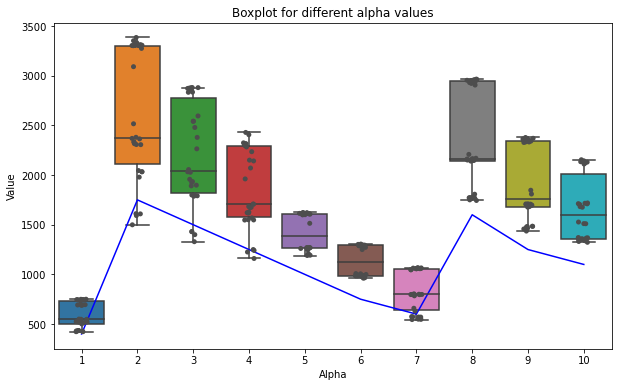

In [88]:
# construct final alpha dataframe
final_alpha_df = pd.DataFrame(final_alpha_list, columns=alpha_name_list)

fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(data=final_alpha_df)
sns.stripplot(data=final_alpha_df, color=".3", size=5)

locs=ax.get_xticks()
ax.plot(locs, alpha_list_true, 'b-')

# label
plt.xlabel('Alpha')
plt.ylabel('Value')
#plt.rc('xtick',labelsize = 15)
#plt.rc('ytick',labelsize = 15)
plt.title('Boxplot for different alpha values') 
fig.savefig("Boxplot for different alpha values")

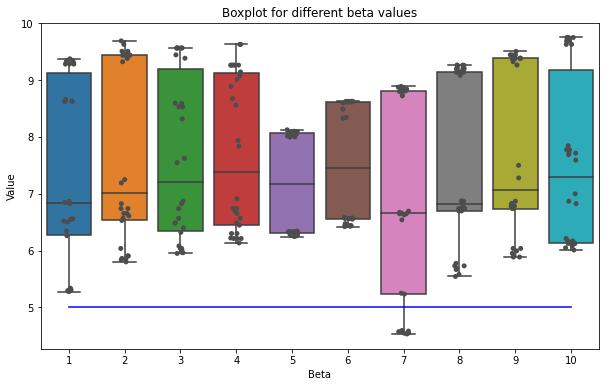

In [89]:
# construct final beta dataframe
final_beta_df = pd.DataFrame(final_beta_list, columns=beta_name_list)

fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(data=final_beta_df)
sns.stripplot(data=final_beta_df, color=".3", size=5)

locs=ax.get_xticks()
ax.plot(locs, beta_list_true, 'b-')

# label
plt.xlabel('Beta')
plt.ylabel('Value')
#plt.rc('xtick',labelsize = 10)
#plt.rc('ytick',labelsize = 10)
plt.title('Boxplot for different beta values') 
fig.savefig("Boxplot for different beta values")

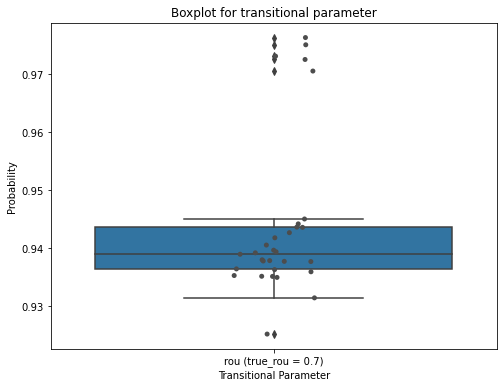

In [91]:
rou = []
for element in final_trans:
    rou.append(element['AUG'])
    
final_trans_df = pd.DataFrame({'rou (true_rou = 0.7)':rou}, columns=['rou (true_rou = 0.7)'])

fig, ax = plt.subplots(figsize = (8, 6))
sns.boxplot(data=final_trans_df)
sns.stripplot(data=final_trans_df, color=".3", size=5)

# plt.axhline(y=0.7, color='r', linestyle='-')

plt.xlabel('Transitional Parameter')
plt.ylabel('Probability')
plt.title('Boxplot for transitional parameter') 
fig.savefig("Boxplot for transitional parameter")

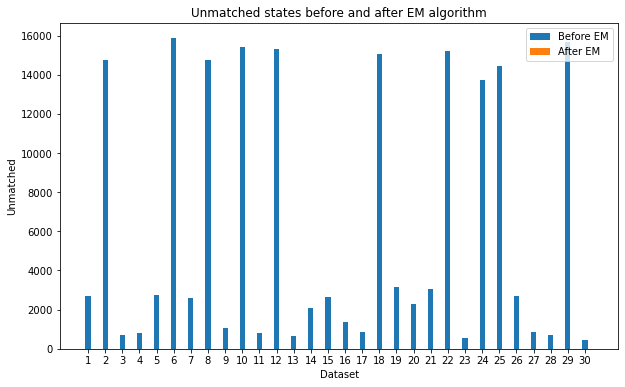

In [92]:
before = differ_state(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, state_list_true)
after = differ_state(RNA_data, observed_data, final_alpha_list, final_beta_list, E, final_trans, stop_codon_list, state_list_true)

# plot
fig, ax = plt.subplots(figsize = (10,6))
plt.xticks(np.arange(1, 31, 1))
ind = np.arange(1, 31, 1)
width = 0.3

# label
plt.bar(ind, before, width, label = 'Before EM')
plt.bar(ind + width, after, width, label = 'After EM') 
plt.xlabel('Dataset')
plt.ylabel('Unmatched')
#plt.rc('xtick',labelsize = 12)
#plt.rc('ytick',labelsize = 12)
plt.title('Unmatched states before and after EM algorithm') 
plt.legend(loc = 'best')
fig.savefig("Unmatched states before and after EM algorithm")

In [185]:
percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, False, state_list_true)

([326,
  336,
  335,
  356,
  327,
  340,
  298,
  332,
  353,
  344,
  326,
  334,
  336,
  301,
  315,
  351,
  330,
  335,
  352,
  330,
  346,
  340,
  323,
  298,
  312,
  328,
  323,
  318,
  348],
 [0.7208588957055214,
  0.6636904761904762,
  0.6985074626865672,
  0.6741573033707865,
  0.6758409785932722,
  0.6941176470588235,
  0.6845637583892618,
  0.6837349397590361,
  0.6685552407932012,
  0.6802325581395349,
  0.7024539877300614,
  0.6976047904191617,
  0.6994047619047619,
  0.7308970099667774,
  0.6825396825396826,
  0.6638176638176638,
  0.6878787878787879,
  0.6865671641791045,
  0.6647727272727273,
  0.696969696969697,
  0.6820809248554913,
  0.6676470588235294,
  0.6996904024767802,
  0.7013422818791947,
  0.7051282051282052,
  0.6920731707317073,
  0.6780185758513931,
  0.7044025157232704,
  0.6752873563218391])

In [93]:
actual_percentage = percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, False, state_list_true)
previous_percentage = percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, True, state_list_true)
estimated_percentage = percent(RNA_data, observed_data, final_alpha_list, final_beta_list, E, final_trans, stop_codon_list, True, state_list_true)

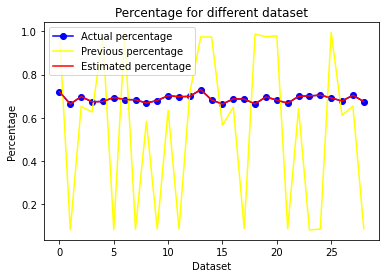

In [95]:
fig, ax = plt.subplots(figsize = (6,4))
plt.plot(actual_percentage, color = 'blue', marker = 'o', label = 'Actual percentage')
plt.plot(previous_percentage, color = 'yellow', label = 'Previous percentage')
plt.plot(estimated_percentage, color = 'red', label = 'Estimated percentage')
plt.legend()
plt.title('Percentage for different dataset')
plt.xlabel('Dataset')
plt.ylabel('Percentage')
plt.show()
fig.savefig("Percentage for different dataset")

In [293]:
alpha_list_true

array([ 400., 1750., 1500., 1250., 1000.,  750.,  600., 1600., 1250.,
       1100.])

In [308]:
a = [np.array([ 10, 10, 10, 10, 10,  10,  10, 10, 10, 10]),
 np.array([30, 80, 70, 60, 50, 40, 30, 60, 50, 40]),
 np.array([30, 80, 70, 60, 50, 40, 30, 60, 50, 40]),
 np.array([ 7, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([30, 80, 70, 60, 50, 40, 30, 60, 50, 40]),
 np.array([ 20, 30, 28, 26, 26,  24,  22, 30, 28, 26]),
 
 np.array([  10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 np.array([ 20, 30, 28, 26, 26,  24,  22, 30, 28, 26]),
 np.array([ 1, 5, 4, 3,  4,  3, 2, 5, 4,3]),
 np.array([ 1, 5, 4, 3,  4,  3, 2, 5, 4,3])]

In [232]:
a = [np.array([ 7, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([30, 80, 70, 60, 50, 40, 30, 60, 50, 40]),
 np.array([30, 80, 70, 60, 50, 40, 30, 60, 50, 40]),
 np.array([ 7, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([20, 80, 70, 60, 50, 40, 30, 60, 50, 40]),
 np.array([ 9, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([ 9, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([  10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 np.array([200, 700, 600, 500, 500, 400, 300, 600, 500, 400]),
 np.array([200, 700, 600, 500, 500, 400, 300, 600, 500, 400])]

In [296]:
b = [np.array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
    np.array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
    np.array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
    np.array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
    np.array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
    np.array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
    np.array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
    np.array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
    np.array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
    np.array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])]

In [309]:
c = [{'AUG': 0.1}, {'AUG':0.8}, {'AUG':0.1}, {'AUG':0.1}, {'AUG': 0.1}, {'AUG':0.4}, {'AUG':0.1}, {'AUG':0.1},
     {'AUG': 0.1}, {'AUG':0.7}]

# beta fixed

In [346]:
def EM_iter(RNA_data, observed_data, trans_init, alpha_init, beta_init, epsilon, max_iter):
    
    trans = trans_init.copy()
    alpha_list = alpha_init.copy()
    beta_list = beta_init
    
    forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
    backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
    
    log_links = []
    log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_init, beta_init, E))
    
    delta = 1
    n_iter = 1
    print(log_links)
    while((delta > epsilon) and (n_iter < max_iter)):
        print("iteration" + str(n_iter))
        #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        curr_trans = trans.copy()
        curr_alpha_list = alpha_list.copy()
        #curr_beta_list = beta_list.copy()
       
        L = compute_L(forward, backward)
        
        #update rho_u_ci, rho_ci, delta_ci
        trans = update_parameter(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        print(trans)
        
        # alpha_list
        state_list = np.arange(10)+1
        random.shuffle(state_list)
        
        for i in state_list:
            state = i
           
            print("state"+str(state))
            res = minimize(object_function_alpha, alpha_list[state-1], method='BFGS', tol = 1, jac=derivative_function_alpha, args = (state, forward, observed_data, beta_list, E, L), options={'disp': False, 'maxiter': 10,'gtol': 1})
            alpha_list[state-1] = res.x[0]
            print("alpha"+str(res.x[0]))
            
            #res = minimize(object_function_beta, beta_list[state-1], method='nelder-mead', tol = 1, args = (state, forward, observed_data, alpha_list, E, L), options={'disp': False})
            #beta_list[state-1] = res.x[0]
            #print("beta"+str(res.x[0]))
           
            
        
        print(alpha_list)
        #print(beta_list)

        
        forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
        
        # log likelihood
        log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E))
        delta = log_links[-1] - log_links[-2]
        n_iter += 1
        
        print(log_links)


    if (delta < 0):
        trans = curr_trans
        alpha_list = curr_alpha_list
        #beta_list = curr_beta_list
        
    return (trans, alpha_list)

In [347]:
# initial value
trans_prob = [{'AUG': 0.1}, {'AUG':0.2}, {'AUG':0.3}, {'AUG':0.4}]
alpha_list_prob = [np.array([ 10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
            np.array([  10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
            np.array([ 1, 5, 4, 3,  4,  3, 2, 5, 4,3])]

In [348]:
final_trans_beta_fixed = []
final_alpha_list_beta_fixed = []
#final_beta_list = []

start_trans_beta_fixed = []
start_alpha_list_beta_fixed = []
#start_beta_list = []

start = 0
count = 1
for end in range(100, 3001, 100): #GAI
    print("count " + str(count))
    
    trans_prob_copy = trans_prob.copy()
    # randomly generate index for trans
    random.seed(end)
    index = random.choice(range(4))
    trans = trans_prob_copy[index]
    start_trans_beta_fixed.append(trans)
    
    # randomly generate index for alpha_list
    random.seed(end+1)
    index = random.choice(range(3))
    alpha_list = alpha_list_prob[index]
    start_alpha_list_beta_fixed.append(alpha_list)
    
    # randomly generate index for beta_list
    #random.seed(end+2)
    #index = random.choice(range(2))
    #beta_list = beta_list_prob[index]
    #start_beta_list.append(beta_list)
    
    # run EM algorithm
    trans_copy = trans.copy()
    alpha_list_copy = alpha_list.copy()
    #beta_list_copy = beta_list.copy()
    
    temp = EM_iter(RNA_data[start:end], observed_data[start:end], trans_copy, alpha_list_copy, beta_list_true, 10e-10, 100)
    final_trans_beta_fixed.append(temp[0])
    final_alpha_list_beta_fixed.append(temp[1])
    #final_beta_list.append(temp[2])
    
    start = end
    
    count += 1

count 1
[-4729.094572259351]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.9710228904734574})
state7
alpha484.45653396753795
state8
alpha1416.943350875379
state3
alpha1058.2513033417172
state2
alpha1219.3501840896556
state5
alpha909.6640872148433
state1
alpha347.7567328975772
state10
alpha1027.35762625116
state6
alpha758.552488009462
state9
alpha1152.8595745568514
state4
alpha925.1179117938227
[ 347 1219 1058  925  909  758  484 1416 1152 1027]
[-4729.094572259351, -143.47619220792586]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9497373647722935})
state2
alpha1747.6927104371362
state6
alpha750.2143595268785
state10
alpha1094.3337920566375
state7
alpha599.6995142650554
state1
alpha399.5413234350622
state9
alpha1254.1683802129617
state3
alpha1461.0457588359266
state4
alpha1241.51079190455
state8
alpha1587.6482697388444
state5
alpha999.3148850557594
[ 399 1747 1461 1241  999  750  599 1587 1254 1094]
[-4729.094572259351, -143.47619220792586, -122.9231479043565]
iteration3
defaul

[-4325.401727012657]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.9785064426378324})
state4
alpha929.7087247383258
state7
alpha484.50322475909263
state3
alpha1080.7300807447377
state9
alpha1132.3222159807824
state6
alpha756.9068893796368
state10
alpha1018.1072680633492
state1
alpha349.5312039851385
state2
alpha1219.7876496677502
state8
alpha1383.9868686269544
state5
alpha902.0897940176612
[ 349 1219 1080  929  902  756  484 1383 1132 1018]
[-4325.401727012657, -130.80351939644152]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9444689279219063})
state7
alpha600.4463727338396
state6
alpha748.5750394204919
state4
alpha1243.3588870359654
state10
alpha1089.6725815626999
state5
alpha998.4099370589122
state2
alpha1734.8461383548943
state3
alpha1479.6642731101354
state1
alpha398.1561415998688
state9
alpha1252.6065632053521
state8
alpha1558.490347135454
[ 398 1734 1479 1243  998  748  600 1558 1252 1089]
[-4325.401727012657, -130.80351939644152, -112.08642224728005]
iteration3
defaultd

[-5447.210765537632, -594.8813452894325, -169.854391231115, -169.854391231115]
count 13
[-4372.788345451965]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.3525779477614156})
state5
alpha958.5956778072953
state10
alpha1076.6551331849664
state9
alpha1186.4793976785215
state4
alpha1139.2853090947851
state3
alpha1351.7433083702583
state1
alpha446.2247193268715
state7
alpha596.1370610481162
state2
alpha1603.7664741058177
state6
alpha733.5399601737864
state8
alpha1548.1445973540092
[ 446 1603 1351 1139  958  733  596 1548 1186 1076]
[-4372.788345451965, -142.2932542555134]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9403271752223411})
state2
alpha1742.5599114794782
state10
alpha1076.0
state9
alpha1242.636312624961
state5
alpha999.5873892926454
state7
alpha599.4191351292716
state3
alpha1496.652422644579
state8
alpha1569.210000000003
state4
alpha1248.1542063898053
state1
alpha400.4704107794696
state6
alpha751.6405194355422
[ 400 1742 1496 1248  999  751  599 1569 1242 1076]
[-4372.78

alpha402.4919301266876
state3
alpha1400.1129643117017
state10
alpha1099.330388588717
[ 402 1609 1400 1132 1001  751  601 1553 1248 1099]
[-3441.896106235791, -581.1979704702368, -110.18833561111174]
iteration3
defaultdict(<class 'float'>, {'AUG': 0.9372638882796716})
state5
alpha1001.0
state7
alpha599.9899999999978
state6
alpha751.0
state4
alpha1236.3373889305235
state8
alpha1553.0
state3
alpha1470.243714792616
state9
alpha1248.0
state2
alpha1747.110363314197
state1
alpha400.98999999999904
state10
alpha1099.0
[ 400 1747 1470 1236 1001  751  599 1553 1248 1099]
[-3441.896106235791, -581.1979704702368, -110.18833561111174, -109.91864983202423]
iteration4
defaultdict(<class 'float'>, {'AUG': 0.9363134226348965})
state8
alpha1553.0
state6
alpha751.0
state2
alpha1747.0
state3
alpha1470.0
state5
alpha1001.0
state7
alpha600.0099999999989
state9
alpha1248.0
state4
alpha1236.0
state10
alpha1099.0
state1
alpha401.01000000000096
[ 401 1747 1470 1236 1001  751  600 1553 1248 1099]
[-3441.896106235

alpha961.7693095588463
state6
alpha734.0719761052453
state2
alpha1636.0431111807625
state10
alpha1082.4631797612383
state8
alpha1564.7932287559183
state4
alpha1159.4840929368513
[ 429 1636 1383 1159  961  734  593 1564 1208 1082]
[-4166.892928269272, -132.9253746806723]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9434358865080705})
state8
alpha1564.0
state7
alpha599.550011042915
state6
alpha749.9540445712229
state3
alpha1500.7650219788156
state4
alpha1229.859207791454
state10
alpha1082.0
state2
alpha1705.7338789820533
state5
alpha999.5208375365223
state9
alpha1224.0183732340377
state1
alpha400.24419482644566
[ 400 1705 1500 1229  999  749  599 1564 1224 1082]
[-4166.892928269272, -132.9253746806723, -128.3404142892619]
iteration3
defaultdict(<class 'float'>, {'AUG': 0.9452064999213988})
state4
alpha1229.0
state5
alpha1000.0100000000012
state7
alpha599.0
state6
alpha750.0099999999976
state2
alpha1705.0
state8
alpha1564.0
state1
alpha401.0099999999988
state3
alpha1500.0
state10
alp

alpha1750.0
state7
alpha599.0100000000003
state8
alpha1567.0
state10
alpha1094.0
state6
alpha749.0
state4
alpha1242.0
state3
alpha1491.0
state9
alpha1231.0
state1
alpha400.0
[ 400 1750 1491 1242  998  749  599 1567 1231 1094]
[-3607.6186714674004, -138.58173918461821, -117.797039032318, -117.797039032318]
count 29
[-3489.387320427365]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.10792705057608251})
state7
alpha620.8293784951275
state1
alpha726.404022429379
state10
alpha1042.8758319154988
state9
alpha1142.367941848889
state8
alpha1538.0437635517942
state5
alpha922.0838951636872
state3
alpha715.2752561609545
state2
alpha953.539615638948
state4
alpha576.6706645710343
state6
alpha717.9501188738175
[ 726  953  715  576  922  717  620 1538 1142 1042]
[-3489.387320427365, -579.1398415997364]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9214583403933426})
state9
alpha1242.2844023008663
state3
alpha1457.8216327759433
state5
alpha999.7555016330073
state2
alpha1713.2631531998136
state10

In [350]:
start_trans_beta_fixed

[{'AUG': 0.2},
 {'AUG': 0.1},
 {'AUG': 0.3},
 {'AUG': 0.3},
 {'AUG': 0.4},
 {'AUG': 0.3},
 {'AUG': 0.2},
 {'AUG': 0.4},
 {'AUG': 0.2},
 {'AUG': 0.4},
 {'AUG': 0.1},
 {'AUG': 0.3},
 {'AUG': 0.3},
 {'AUG': 0.2},
 {'AUG': 0.3},
 {'AUG': 0.1},
 {'AUG': 0.4},
 {'AUG': 0.3},
 {'AUG': 0.1},
 {'AUG': 0.4},
 {'AUG': 0.3},
 {'AUG': 0.3},
 {'AUG': 0.4},
 {'AUG': 0.1},
 {'AUG': 0.1},
 {'AUG': 0.4},
 {'AUG': 0.2},
 {'AUG': 0.3},
 {'AUG': 0.3},
 {'AUG': 0.2}]

In [97]:
start_alpha_list_beta_fixed = [np.array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 np.array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 np.array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 np.array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 np.array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 np.array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 np.array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 np.array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 np.array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 np.array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 np.array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 np.array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 np.array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 np.array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 np.array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 np.array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 np.array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 np.array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 np.array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 np.array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 np.array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17])]

In [352]:
final_trans_beta_fixed

[defaultdict(float, {'AUG': 0.9445101034634937}),
 defaultdict(float, {'AUG': 0.9336444641697239}),
 defaultdict(float, {'AUG': 0.942619884496885}),
 defaultdict(float, {'AUG': 0.9307287347076997}),
 defaultdict(float, {'AUG': 0.939218793442078}),
 defaultdict(float, {'AUG': 0.9367425794076548}),
 defaultdict(float, {'AUG': 0.9398083433656073}),
 defaultdict(float, {'AUG': 0.9370985379479836}),
 defaultdict(float, {'AUG': 0.9340764677084072}),
 defaultdict(float, {'AUG': 0.9388777691998584}),
 defaultdict(float, {'AUG': 0.9431513737645072}),
 defaultdict(float, {'AUG': 0.936481396639112}),
 defaultdict(float, {'AUG': 0.9437511268297042}),
 defaultdict(float, {'AUG': 0.9462909224536358}),
 defaultdict(float, {'AUG': 0.9422938492314017}),
 defaultdict(float, {'AUG': 0.9350094292844511}),
 defaultdict(float, {'AUG': 0.9388712996956153}),
 defaultdict(float, {'AUG': 0.9372638882796716}),
 defaultdict(float, {'AUG': 0.9341139323301236}),
 defaultdict(float, {'AUG': 0.9334996204577198}),
 de

In [353]:
final_alpha_list_beta_fixed

[array([ 399, 1747, 1461, 1241,  999,  750,  600, 1587, 1254, 1094]),
 array([ 400, 1748, 1503, 1248,  998,  748,  599, 1563, 1247, 1098]),
 array([ 400, 1740, 1496, 1253,  998,  749,  601, 1561, 1218, 1082]),
 array([ 399, 1741, 1495, 1246,  999,  748,  599, 1571, 1252, 1085]),
 array([ 399, 1744, 1465, 1241,  999,  749,  602, 1605, 1234, 1094]),
 array([ 400, 1738, 1477, 1239, 1000,  749,  599, 1565, 1227, 1095]),
 array([ 398, 1734, 1479, 1243,  998,  748,  601, 1558, 1252, 1089]),
 array([ 399, 1750, 1486, 1248, 1000,  750,  598, 1565, 1224, 1106]),
 array([ 399, 1751, 1489, 1247,  998,  750,  600, 1598, 1250, 1083]),
 array([ 399, 1731, 1473, 1234,  999,  750,  598, 1568, 1247, 1100]),
 array([ 400, 1741, 1495, 1251,  998,  751,  601, 1564, 1217, 1089]),
 array([ 401, 1714, 1468, 1227, 1001,  751,  600, 1571, 1247, 1100]),
 array([ 400, 1742, 1496, 1248, 1000,  751,  600, 1569, 1242, 1076]),
 array([ 398, 1694, 1478, 1248, 1000,  750,  600, 1577, 1254, 1099]),
 array([ 399, 1737, 

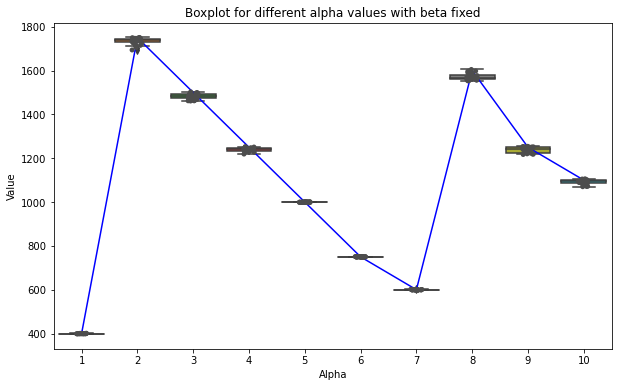

In [103]:
alpha_name_list = []
for i in range(1, 11):
    alpha_name_list.append(str(i))
    

final_alpha_df_beta_fixed = pd.DataFrame(final_alpha_list_beta_fixed, columns=alpha_name_list)


fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(data=final_alpha_df_beta_fixed)
sns.stripplot(data=final_alpha_df_beta_fixed, color = '.3', size = 5)

locs=ax.get_xticks()
ax.plot(locs, alpha_list_true, 'b-')

plt.xlabel('Alpha')
plt.ylabel('Value')
#plt.rc('xtick', labelsize = 15)
#plt.rc('ytick', labelsize = 15)
plt.title('Boxplot for different alpha values with beta fixed') 
fig.savefig("Boxplot for different alpha values with beta fixed")

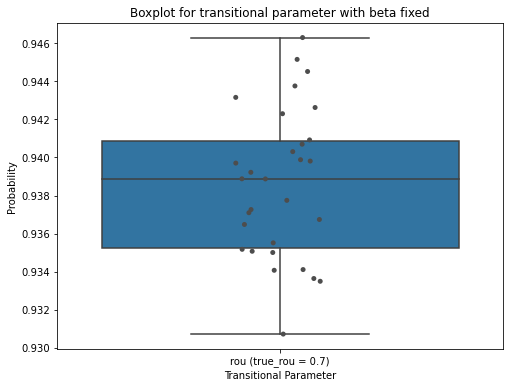

In [104]:
rou_beta_fixed = []
for element in final_trans_beta_fixed:
    rou_beta_fixed.append(element['AUG'])
    
final_trans_df_beta_fixed = pd.DataFrame({"rou (true_rou = 0.7)":rou_beta_fixed}, columns=['rou (true_rou = 0.7)'])

fig, ax = plt.subplots(figsize = (8, 6))
sns.boxplot(data=final_trans_df_beta_fixed)
sns.stripplot(data=final_trans_df_beta_fixed, color=".3", size=5)

#plt.axhline(y=0.7, color='r', linestyle='-')

plt.xlabel('Transitional Parameter')
plt.ylabel('Probability')
plt.title('Boxplot for transitional parameter with beta fixed') 
fig.savefig("Boxplot for transitional parameter with beta fixed")

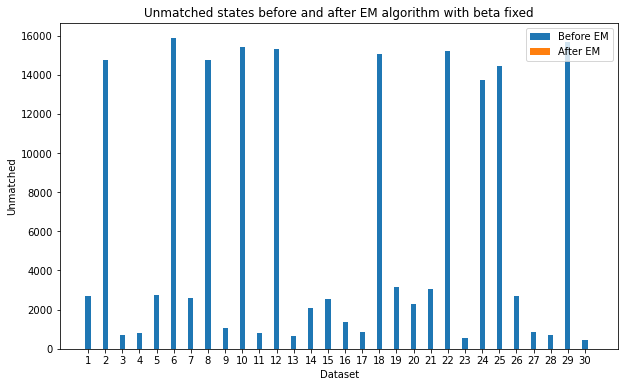

In [105]:
beta_list_beta_fixed = np.repeat([beta_list_true],30, axis = 1).reshape(30,10)

before_beta_fixed = differ_state(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, state_list_true)
after_beta_fixed = differ_state(RNA_data, observed_data, final_alpha_list_beta_fixed, beta_list_beta_fixed, E, final_trans_beta_fixed, stop_codon_list, state_list_true)

# plot
fig, ax = plt.subplots(figsize = (10,6))
plt.xticks(np.arange(1, 31, 1))
ind = np.arange(1, 31, 1)
width = 0.3

# label
plt.bar(ind, before_beta_fixed, width, label = 'Before EM')
plt.bar(ind + width, after_beta_fixed, width, label = 'After EM') 
plt.xlabel('Dataset')
plt.ylabel('Unmatched')
plt.title('Unmatched states before and after EM algorithm with beta fixed') 
plt.legend(loc = 'best')
fig.savefig("Unmatched states before and after EM algorithm with beta fixed")

In [ ]:
actual_percentage_beta_fixed = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, False, state_list_true)
previous_percentage_beta_fixed = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, True, state_list_true)
estimated_percentage_beta_fixed = percent(RNA_data, observed_data, final_alpha_list_beta_fixed, beta_list_beta_fixed, E, final_trans_beta_fixed, stop_codon_list, True, state_list_true)

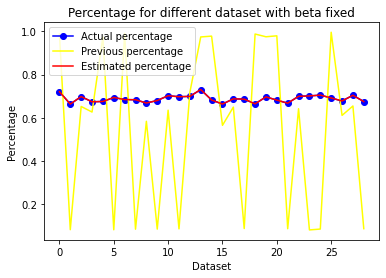

In [106]:
# Plot the graph with n features versus accuracy when it's 5-NN algorithms
fig, ax = plt.subplots(figsize = (6,4))
plt.plot(actual_percentage_beta_fixed, color = 'blue', marker = 'o', label = 'Actual percentage')
plt.plot(previous_percentage_beta_fixed, color = 'yellow', label = 'Previous percentage')
plt.plot(estimated_percentage_beta_fixed, color = 'red', label = 'Estimated percentage')
plt.legend()
plt.title('Percentage for different dataset with beta fixed')
plt.xlabel('Dataset')
plt.ylabel('Percentage')
plt.show()
fig.savefig("Percentage for different dataset")